In [144]:
# do check the kernel is python3 , NOT python2
!pip install tensorflow==1.12
import matplotlib.pyplot as plot
import numpy as np
import pandas as pd
import datetime
import math
from pandas.io import gbq
import tensorflow as tf
import re
from tensorflow import keras
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [145]:
query = """
#standardSQL
CREATE TEMP FUNCTION
  customDimensionByIndex(indx INT64,
    arr ARRAY<STRUCT<index INT64,
    value STRING>>) AS ( (
    SELECT
      x.value
    FROM
      UNNEST(arr) x
    WHERE
      indx=x.index) );
SELECT
  fullVisitorId,
  visitId,
  trafficSource.source, 
  device.browser,
  device.operatingSystem,
  device.LANGUAGE,
  device.deviceCategory,
  
 ---session scope custom dimension---
  customDimensionByIndex(3,
    t.customDimensions) AS contentCategory, #mostly null
  ---User scope custom dimension---
  customDimensionByIndex(5,
    t.customDimensions) AS userGender
FROM
  `tencent-ga-bigquery-217708.18845258.ga_sessions_*`t
  --,UNNEST (hits) AS h
WHERE
  _TABLE_SUFFIX BETWEEN '20181001' AND '20181201' 
    --filter out rows that gender is null
   AND (
    LOWER(customDimensionByIndex(5,t.customDimensions)) = 'female' --userGender
    OR 
    LOWER(customDimensionByIndex(5,t.customDimensions)) = 'male'
   )
  
LIMIT 2000000
""" 

data_original = gbq.read_gbq(query,project_id = "tencent-ga-bigquery-217708" )


Requesting query... ok.
Job ID: 886688d6-eb47-4b7a-a2de-d94ddd4c9f5b
Query running...
  Elapsed 8.12 s. Waiting...
  Elapsed 9.78 s. Waiting...
  Elapsed 11.17 s. Waiting...
  Elapsed 12.42 s. Waiting...
  Elapsed 13.79 s. Waiting...
  Elapsed 15.16 s. Waiting...
Query done.
Processed: 34.6 GB Billed: 34.6 GB
Standard price: $0.17 USD

Retrieving results...
Got 2000000 rows.

Total time taken 265.63 s.
Finished at 2019-01-29 09:35:56.


In [146]:
data = data_original.copy()
print(data.columns)
print(data.shape)

Index(['fullVisitorId', 'visitId', 'source', 'browser', 'operatingSystem',
       'LANGUAGE', 'deviceCategory', 'contentCategory', 'userGender'],
      dtype='object')
(2000000, 9)


In [147]:
# remove rows with null values
data.dropna(axis=0, inplace=True)

#rename column LANGUAGE to language
data.rename(columns = {'LANGUAGE':'language'}, inplace=True)


In [148]:
# count sessions for each fullVisitorId and store in datafame sessionCount
sessions = data.loc[:,['fullVisitorId','visitId']].drop_duplicates()
sessionCount = sessions.groupby(by='fullVisitorId').count()
sessionCount.columns = ['counts']

#remove unused columns
data = data.drop(['visitId'],axis=1)

In [149]:
data.columns

Index(['fullVisitorId', 'source', 'browser', 'operatingSystem', 'language',
       'deviceCategory', 'contentCategory', 'userGender'],
      dtype='object')

In [150]:
##### retain only top values in each column and change the rest to 'other' ###########

# prepare column browser, change browers that are not specified below to 'other'
print('BEFORE:\n')
print(data.browser.value_counts(),'\n')
data.loc[(data.browser != 'Chrome') &
         (data.browser != 'Safari') &
         (data.browser != 'Firefox') &
         (data.browser != 'Samsung Internet') &
         (data.browser != 'Android Webview') &
         (data.browser != 'Edge') &
         (data.browser !='Internet Explorer'),'browser'] = 'other'
print('AFTER:\n')
print(data.browser.value_counts(),'\n')


# prepare column language

data.loc[data.language.str.contains('en'),'language'] = 'en'  #data has inconsistent values e.g. 'en','en-en','en-bg'
data.loc[data.language.str.contains('th'),'language'] = 'th'
data.language.str.contains('en|th')
data.loc[(data.language!='th') & 
         (data.language!='en'),'language'] = 'other'



# prepare column operatingSystem

data.loc[(data.operatingSystem != 'Windows') &
         (data.operatingSystem != 'Android') &
         (data.operatingSystem != 'Macintosh') &
         (data.operatingSystem !='iOS'),'operatingSystem'] = 'other'


# prepare column source 

data.loc[data.source.str.contains('facebook'),'source'] = 'facebook' #data has inconsistent value such as 'facebook','facebook.com'
data.loc[data.source.str.contains('google'),'source'] = 'google'
data.loc[data.source.str.contains('sanook'),'source'] = 'sanook'
data.loc[data.source.str.contains('direct'),'source'] = 'direct'
data.loc[(data.source != 'facebook') &
         (data.source != 'google') &
         (data.source != 'sanook') &
         (data.source !='direct'),'source'] = 'other'



# remove rows where contentCategory contains non-english characters
data = data[data.contentCategory.str.contains('^[A-Za-z]+$', regex=True)]
data.loc[:,'contentCategory'] = data.contentCategory.str.lower()
data.loc[:,'userGender'] = data.userGender.str.lower()
# female=0, male=1
data.userGender.replace({
  'female':'0',
  'male':'1'
}, inplace=True)  


print(data.shape)

BEFORE:

Chrome                      813058
Safari                      110191
Samsung Internet             51367
Android Webview              33147
Firefox                      18203
Opera                        11553
Internet Explorer            10405
Edge                          4444
Safari (in-app)               2840
UC Browser                    1032
Maxthon                        144
Android Browser                129
Puffin                          83
Nokia Browser                   35
YaBrowser                       20
Opera Mini                      16
Coc Coc                          9
Amazon Silk                      7
Mozilla Compatible Agent         1
BlackBerry                       1
i-mobile i-STYLE 8.5             1
Name: browser, dtype: int64 

AFTER:

Chrome               813058
Safari               110191
Samsung Internet      51367
Android Webview       33147
Firefox               18203
other                 15871
Internet Explorer     10405
Edge                  

In [151]:
data_before_pivot = data.copy()

In [152]:
# this function makes pivot table 
def make_pivot_table(columns):
    result =None
    for column in columns:
        pivot = data.loc[:,['fullVisitorId',column]]
        pivot = pivot.pivot_table(index='fullVisitorId',columns=column,aggfunc= any)
        pivot.columns = ['_'.join((column,i)) for i  in pivot.columns]
        if result is None:
          result = pivot
        else:
          result = result.join(pivot)       
    result = result.replace({
      True:1,
      None:0
    })
    return result

gender = data.loc[:,['fullVisitorId','userGender']].drop_duplicates().set_index('fullVisitorId')    
data = make_pivot_table(data.columns[1:-1])
data = data.join(gender)
data_after_pivot=data.copy()
print(data.shape)

(447220, 185)


In [153]:
#remove columns with sessionCount <10 
data = data.join(sessionCount)
data = data[data.counts>=5].drop('counts',axis=1)
print(data.shape)

(35582, 185)


In [154]:
#remove columns with less than 0.1% of 1s  
# data = data[data.columns[data.sum()>data.shape[0]*0.001]]
# data.shape

In [155]:
# split train and test set 
train_dataset, test_dataset, train_labels, test_labels = train_test_split(data.drop('userGender',axis=1), data['userGender'], test_size = 0.2, random_state = 100)

#covnert dataframe to ndarrays for tensorflow input 
train_dataset = train_dataset.values
train_labels = train_labels.values
test_dataset = test_dataset.values
test_labels = test_labels.values


In [156]:
#1

model1 = keras.Sequential([
    keras.layers.Dense(4, activation=tf.nn.relu, input_shape = (train_dataset.shape[1],)),
    keras.layers.Dense(4, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

model1.compile(optimizer=tf.train.AdamOptimizer(), 
              loss= 'sparse_categorical_crossentropy',
              metrics=['accuracy'])

history1 = model1.fit(train_dataset,train_labels, epochs =30, batch_size = 1000 ,validation_split=0.1, verbose=0)
results = model1.evaluate(test_dataset, test_labels)
print(results)


7117/7117 [==============================] - 0s 33us/step
[0.558232230560254, 0.7306449346886067]


In [157]:
#2

model2 = keras.models.Sequential([
    keras.layers.Dense(128, kernel_regularizer=keras.regularizers.l2(0.001),
                       activation=tf.nn.relu, input_shape=(train_dataset.shape[1],)),
    keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model2.compile(optimizer='adam',
                 loss='binary_crossentropy',
                 metrics=['accuracy'])

history2 = model2.fit(train_dataset,train_labels, epochs =30, batch_size = 1000 ,validation_split=0.1, verbose=0)
results = model2.evaluate(test_dataset, test_labels)
print(results)

7117/7117 [==============================] - 0s 35us/step
[0.5640014533382195, 0.7303639174060438]


In [158]:
# 3
model3 = keras.models.Sequential([
    keras.layers.Dense(128, activation=tf.nn.relu, input_shape=(train_dataset.shape[1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation=tf.nn.sigmoid)
])

model3.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

history3 = model3.fit(train_dataset,train_labels, epochs =30, batch_size = 5000 ,validation_split=0.1, verbose=0)
results = model3.evaluate(test_dataset, test_labels)
print(results)

7117/7117 [==============================] - 0s 39us/step
[0.5533073649775602, 0.7347196852857685]


In [159]:
# 4
model4 = keras.models.Sequential([
    keras.layers.Dense(128, kernel_regularizer=keras.regularizers.l2(0.001), activation=tf.nn.relu, input_shape=(train_dataset.shape[1],)),
    keras.layers.Dense(128, kernel_regularizer=keras.regularizers.l2(0.001), activation=tf.nn.relu),    
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

model4.compile(optimizer='rmsprop',  
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

history4 = model4.fit(train_dataset,train_labels, epochs =30, batch_size = 5000, validation_split=0.1 ,verbose=0)
results = model4.evaluate(test_dataset, test_labels)
print(results)

7117/7117 [==============================] - 0s 40us/step
[0.6007746694311427, 0.7326120556665469]


Text(0.5,1,'comparison of different models')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


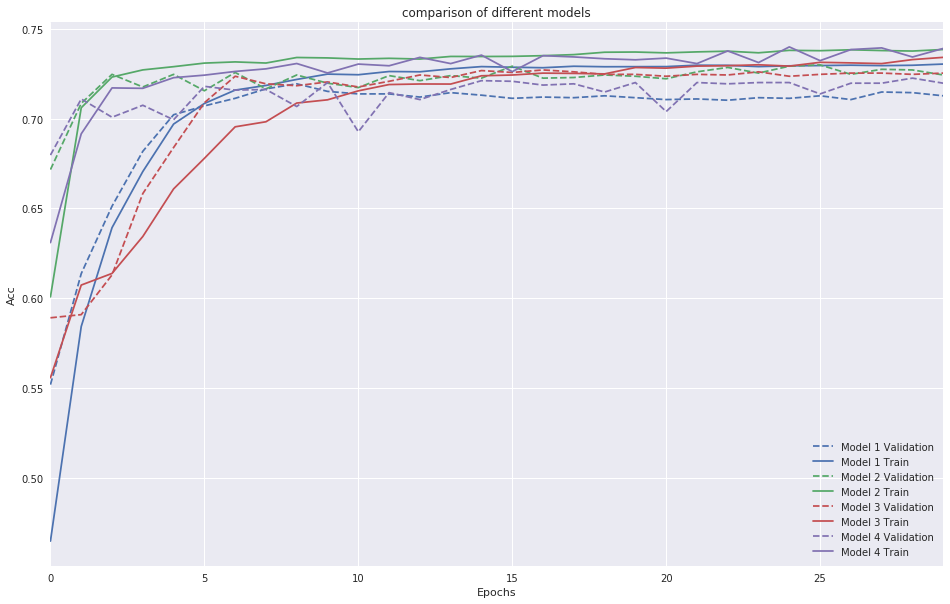

In [160]:
def plot_history(histories, key='acc'):
  plot.figure(figsize=(16,10))
  for name, history in histories:
    val = plot.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Validation')
    plot.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plot.xlabel('Epochs')
  plot.ylabel(key.replace('_',' ').title())
  plot.legend()
  plot.xlim([0,max(history.epoch)])
  
  
plot_history([('model 1',history1),('model 2',history2),('model 3',history3),('model 4',history4)])
plot.title('comparison of different models')

In [161]:
test_prediction = model3.predict(test_dataset)
test_prediction =  pd.DataFrame(test_prediction).apply(np.argmax, axis =1)

/usr/local/envs/py3env/lib/python3.5/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Text(33,0.5,'actual')

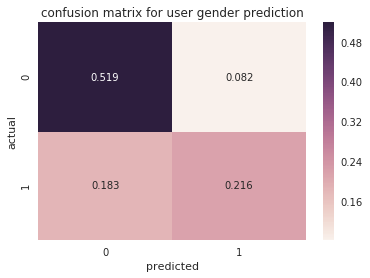

In [162]:
test_labels = test_labels.astype('int')
cm = confusion_matrix(test_labels, test_prediction)/test_labels.shape[0]
sns.heatmap(cm,annot=True, fmt='.3f') 
plot.title('confusion matrix for user gender prediction')
plot.xlabel('predicted')
plot.ylabel('actual')

In [163]:
###############################################################################
### explore the relationship between session count and model accuracy #########
###############################################################################


In [164]:
#remove columns with sessionCount <5 
session5 = data_after_pivot.copy()
session5 = session5.join(sessionCount)
session5 = session5[session5.counts>=5].drop('counts',axis=1)
print(session5.shape)

session5_labels = session5.userGender
session5_data  = session5.drop('userGender',axis=1)
session5_data_train, session5_data_test, session5_labels_train, session5_labels_test = train_test_split(session5_data,session5_labels,test_size=0.2, random_state=1000)


(35582, 185)


In [165]:
#remove columns with sessionCount <10 
session10 = data_after_pivot.copy()
session10 = session10.join(sessionCount)
session10 = session10[session10.counts>=10].drop('counts',axis=1)
print(session10.shape)

session10_labels = session10.userGender
session10_data  = session10.drop('userGender',axis=1)
session10_data_train, session10_data_test, session10_labels_train, session10_labels_test = train_test_split(session10_data,session10_labels,test_size=0.2, random_state=1000)


(14291, 185)


In [166]:
#remove columns with sessionCount <15 
session15 = data_after_pivot.copy()
session15 = session15.join(sessionCount)
session15 = session15[session15.counts>=15].drop('counts',axis=1)
print(session15.shape)

session15_labels = session15.userGender
session15_data  = session15.drop('userGender',axis=1)
session15_data_train, session15_data_test, session15_labels_train, session15_labels_test = train_test_split(session15_data,session15_labels,test_size=0.2, random_state=1000)


(7847, 185)


In [167]:
# #remove columns with sessionCount <20 
session20 = data_after_pivot.copy()
session20 = session20.join(sessionCount)
session20 = session20[session20.counts>=20].drop('counts',axis=1)
print(session20.shape)

session20_labels = session20.userGender
session20_data  = session20.drop('userGender',axis=1)
session20_data_train, session20_data_test, session20_labels_train, session20_labels_test = train_test_split(session20_data,session20_labels,test_size=0.2, random_state=1000)


(4637, 185)


In [168]:
model = keras.models.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(train_dataset.shape[1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
history_session5 = model.fit(session5_data_train,session5_labels_train, epochs =40, batch_size = 5000 ,validation_split=0.1, verbose=0)


In [169]:
model = keras.models.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(train_dataset.shape[1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
history_session10 = model.fit(session10_data_train,session10_labels_train, epochs =40, batch_size = 5000 ,validation_split=0.1, verbose=0)


In [170]:
model = keras.models.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(train_dataset.shape[1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])

model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
history_session15 = model.fit(session15_data_train,session15_labels_train, epochs =40, batch_size = 5000 ,validation_split=0.1, verbose=0)


In [171]:
model = keras.models.Sequential([
    keras.layers.Dense(64, activation=tf.nn.relu, input_shape=(train_dataset.shape[1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation=tf.nn.softmax)
])
  
model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
history_session20 = model.fit(session20_data_train,session20_labels_train, epochs =40, batch_size = 5000 ,validation_split=0.1, verbose=0)


Text(0.5,1,'comparison of accurary for numbers of session for user gender prediction')

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


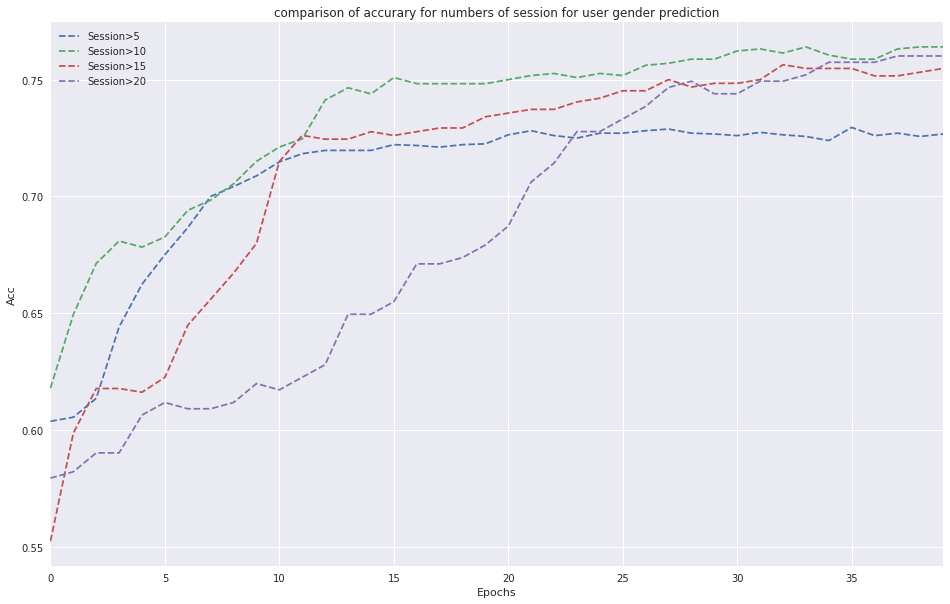

In [172]:
def plot_history_val(histories, key='acc'):
  plot.figure(figsize=(16,10))
  for name, history in histories:
    val = plot.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title())
    plot.xlabel('Epochs')
    plot.ylabel(key.replace('_',' ').title())
    plot.legend()
    plot.xlim([0,max(history.epoch)])

plot_history_val([('session>5',history_session5),('session>10',history_session10),('session>15',history_session15),('session>20',history_session20)])
plot.title('comparison of accurary for numbers of session for user gender prediction')

In [173]:
# acc = history.history['acc']
# val_acc = history.history['val_acc']
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(acc) + 1)


# plot.figure(figsize=(12,10))
# plot.subplot(2,1,1)
# # "bo" is for "blue dot"
# plot.plot(epochs, loss, 'bo', label='Training loss')
# # b is for "solid blue line"
# plot.plot(epochs, val_loss, 'b', label='Validation loss')
# plot.title('Training and validation loss')
# plot.xlabel('Epochs')
# plot.ylabel('Loss')
# plot.legend()
# plot.show()
# plot.figure(figsize=(12,10))
# plot.subplot(2,1,2)
# # "bo" is for "blue dot"
# plot.plot(epochs, acc, 'bo', label='Training accuracy')
# # 'b' is for "solid blue line"
# plot.plot(epochs, val_acc, 'b', label='Validation accuracy')
# plot.title('Training and validation accuracy')
# plot.xlabel('Epochs')
# plot.ylabel('Loss')
# plot.legend()
# plot.show()